In [2]:
# Import libraries.
import qiskit
import numpy

# Quantum Fourier Transform

In [3]:
def create_qft_circuit(n):
    qc = qiskit.QuantumCircuit(n)
    
    # Applying the phases.
    for i in range(n - 1, -1, -1):
        for j in range(i, -1, -1):
            if i == j:
                qc.h(i)
            else:
                qc.cp(numpy.pi / (2 ** (i - j)), i, j)
                
    # Swapping the output qubits.
    for i in range(n // 2):
        qc.swap(i, n - i - 1)

    return qc
def create_qft_gate(n):
    qc = create_qft_circuit(n)
    gate = qc.to_gate()
    gate.label = "QFT"
    return gate
def create_qft_inverse_gate(n):
    qc = create_qft_circuit(n)
    gate = qc.to_gate().inverse()
    gate.label = "QFT Inv"
    return gate

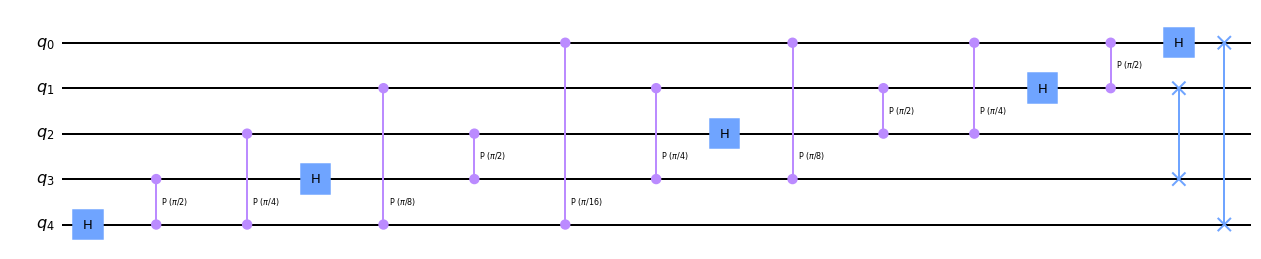

In [70]:
create_qft_circuit(5).draw(output = "mpl", scale = 1.0, fold = -1)

# QFT addition
Addition algorithm is from https://arxiv.org/abs/quant-ph/0008033. This is a modified version of this. It adds the number $a$ (in binary) to the fourier transformed value $|f \rangle$ (in binary).
Note, $a$ should not be in binary format, but as an integer in the argument.

In [5]:
def create_qft_add_circuit(a, digits):
    # The number "a" and the fourier transformed number "f" ("digits" bits) to be added.
    # "a" has be able to be represented on "digits" bits.
    
    # Convert "a" to binary in reverse, so a_binary[i] = a_i,
    # where a = sum_i 2^i * a_i.
    a_binary = format(a, "0" + str(digits) + "b")[::-1]
    
    # Setup qubits.
    qreg_f = qiskit.QuantumRegister(digits, "f")
    qc = qiskit.QuantumCircuit(qreg_f)

    # Applying the phases.
    for i in range(digits - 1, -1, -1):
        for j in range(i, -1, -1):
            if a_binary[j] == "1":
                # Note, (digits-i-1) corresponds to i in the referred article,
                # because our QFT swaps the output qubits.
                qc.p(numpy.pi / (2 ** (i - j)), qreg_f[digits - i - 1])

    return qc
def create_qft_add_gate(a, digits):
    qc = create_qft_add_circuit(a, digits)
    gate = qc.to_gate()
    gate.label = "QFT Add"
    return gate
def create_qft_add_controlled_gate(a, digits):
    gate = create_qft_add_gate(a, digits).control()
    return gate

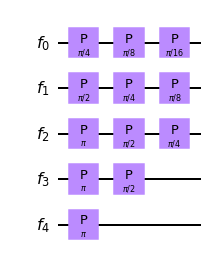

In [72]:
create_qft_add_circuit(7, 5).draw(output = "mpl", scale = 1.0, fold = -1)

# Addition
This gate performs addition on multiple numbers. It applies to $|x\rangle|target\rangle$. $|x\rangle$ is the bit representation of which numbers are added together from the list `numbers`. The output on $|target\rangle$ is simply the sum of these numbers. The $|target\rangle$ is represented on `digits` bits.

In [7]:
def create_add_circuit(numbers, digits):
    qreg_x = qiskit.QuantumRegister(len(numbers), "x")
    qreg_target = qiskit.QuantumRegister(digits, "target")
    qc = qiskit.QuantumCircuit(qreg_x, qreg_target)
    
    # First, we apply a QFT on |target>.
    #qc.append(create_qft_gate(digits), target)
    # We assume, that the |target initially is |0>, so we only need Hadamards.
    qc.h(qreg_target)
    
    for i in range(len(numbers)):
        qc.append(create_qft_add_controlled_gate(numbers[i], digits),
            [qreg_x[i]] + qreg_target[:])
    
    qc.append(create_qft_inverse_gate(digits), qreg_target)

    return qc
def create_add_gate(numbers, digits):
    qc = create_add_circuit(numbers, digits)
    gate = qc.to_gate()
    gate.label = "Add"
    return gate

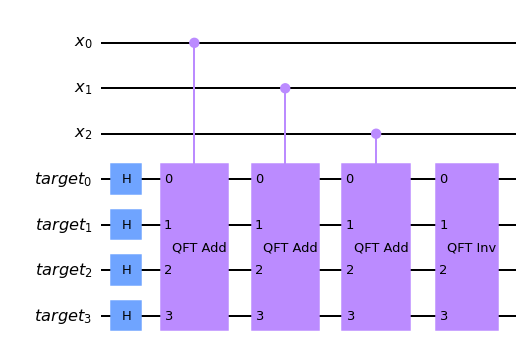

In [74]:
create_add_circuit([1, 2, 3], 4).draw(output = "mpl", scale = 1.0, fold = -1)

# Testing the addition

{'01101 10011': 10}
{13: 10}


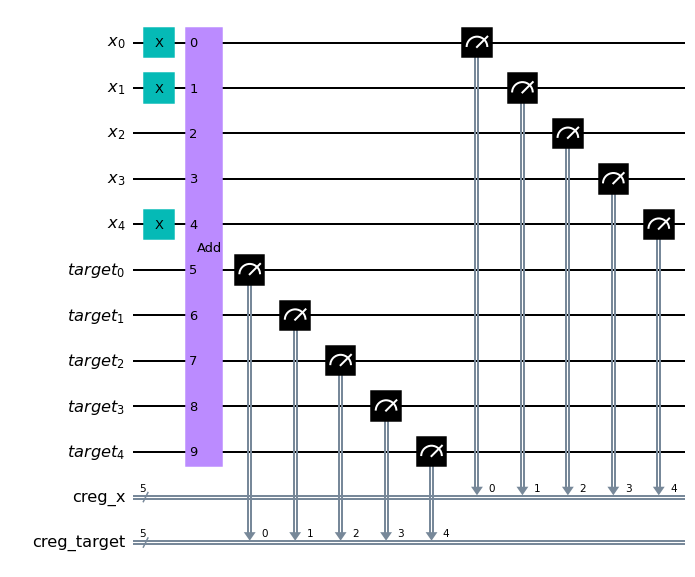

In [9]:
numbers_test = [4, 6, 8, 5, 3]
digits_test = 5

# Initialize the qubits.
qreg_x = qiskit.QuantumRegister(len(numbers_test), "x")
qreg_target = qiskit.QuantumRegister(digits_test, "target")
creg_x = qiskit.ClassicalRegister(digits_test, "creg_x")
creg_target = qiskit.ClassicalRegister(digits_test, "creg_target")
qc = qiskit.QuantumCircuit(qreg_x, qreg_target, creg_x, creg_target)

qc.x(qreg_x[0])
qc.x(qreg_x[1])
#qc.x(qreg_x[2])
#qc.x(qreg_x[3])
qc.x(qreg_x[4])

# Addition operation.
qc.append(create_add_gate(numbers_test, digits_test), qreg_x[:] + qreg_target[:])

# Measurement operation.
qc.measure(qreg_target, creg_target)
qc.measure(qreg_x, creg_x)

# Execute the circuit, print outcomes.
job = qiskit.execute(qc, qiskit.Aer.get_backend("qasm_simulator"), shots = 10)
counts = job.result().get_counts(qc)

# Translate output to integer from binary.
counts_int = {}
for key in counts:
    new_key = int(key[:digits_test], 2)
    counts_int[new_key] = counts[key]
print(counts)
print(counts_int)

#qiskit.visualization.plot_histogram(counts_int)
qc.draw(output = "mpl", scale = 1.0, fold = -1)

# Grover Oracle

The $|target\rangle$ qubits store the sum of the numbers, and the $|x\rangle$ qubits store which of the numbers should be added together by the Oracle.

What this Oracle does is simply
$$|x \rangle |y \rangle |target \rangle \mapsto |x \rangle |f(x) \oplus y \rangle |target \rangle ,$$
where $f(x)$ is going to be $1$, if the addition of the inputs - marked by $x$ - results the number we want, and $0$ otherwise.

This means, that if the $|y\rangle$ qubit is initially $|-\rangle$, the application of this Oracle does $|x \rangle |y \rangle \mapsto (-1)^{f(x)} |y \rangle$.

## Validator
This gate validates whether a specific combination of numbers do add up to the value in question.

The qubits $|x \rangle$ encodes which numbers we add together.

### Checking the result
This gate will set the the result of the addition to all $|1\rangle$, when the result is the sum in question. This is needed, because using a controlled not on these qubits, we can later create $|f(x) \oplus y\rangle$.

In [76]:
def create_checker_circuit(expected_sum, digits):
    qreg_target = qiskit.QuantumRegister(digits, "target")
    qc = qiskit.QuantumCircuit(qreg_target)
    formatted = format(expected_sum, "0" + str(digits) + "b")
    for i in range(digits):
        if formatted[i] == "0":
            qc.x(qreg_target[digits - i - 1])
    return qc
def create_checker_gate(expected_sum, digits):
    qc = create_checker_circuit(expected_sum, digits)
    gate = qc.to_gate()
    gate.label = "Checker"
    return gate

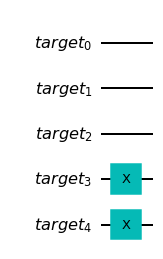

In [79]:
create_checker_circuit(7, 5).draw(output = "mpl", scale = 1.0, fold = -1)

### Creating the whole validator

In [12]:
def create_validator_circuit(numbers, expected_sum, digits):
    qreg_x = qiskit.QuantumRegister(len(numbers), "x")
    qreg_target = qiskit.QuantumRegister(digits, "target")
    qc = qiskit.QuantumCircuit(qreg_x, qreg_target)
    
    # Add the numbers together.
    qc.append(create_add_gate(numbers, digits),
        qreg_x[:] + qreg_target[:])

    # Check whether the result is the expected sum.
    qc.append(create_checker_gate(expected_sum, digits),
        qreg_target)

    return qc
def create_validator_gate(numbers, expected_sum, digits):
    qc = create_validator_circuit(numbers, expected_sum, digits)
    gate = qc.to_gate()
    gate.label = "Validator"
    return gate
def create_validator_inverse_gate(numbers, expected_sum, digits):
    qc = create_validator_circuit(numbers, expected_sum, digits)
    gate = qc.to_gate().inverse()
    gate.label = "Validator Inv"
    return gate

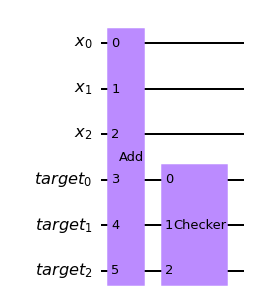

In [82]:
create_validator_circuit([1, 2, 3], 6, 3).draw(output = "mpl", scale = 1.0, fold = -1)

## Creating the whole Grover Oracle
The Grover Oracle will compute whether the combination of the numbers (stored in $|x\rangle$) adds up to `expected_sum`. If, and only if it is, it applies an $X$ gate to the qubit $|y\rangle$.

To do that, we apply the validator gate, apply the controlled not to $|y \rangle$, and then do an uncomputation of the validator circuit.

$$|x \rangle |y \rangle |target \rangle \mapsto |x \rangle |f(x) \oplus y \rangle |target \rangle.$$

In [14]:
def create_grover_oracle_circuit(numbers, expected_sum, digits):
    qreg_x = qiskit.QuantumRegister(len(numbers), "x")
    qreg_y = qiskit.QuantumRegister(1, "y")
    qreg_target = qiskit.QuantumRegister(digits, "target")
    qc = qiskit.QuantumCircuit(qreg_x, qreg_y, qreg_target)
    
    qc.append(create_validator_gate(numbers, expected_sum, digits),
        qreg_x[:] + qreg_target[:])
    
    # Create a multi controlled not gate on the target, which is |y>, and the controls are the outputs of the checker.
    qc.mcx(qreg_target[:], qreg_y)
    
    qc.append(create_validator_inverse_gate(numbers, expected_sum, digits),
        qreg_x[:] + qreg_target[:])
    
    return qc
def create_grover_oracle_gate(numbers, expected_sum, digits):
    qc = create_grover_oracle_circuit(numbers, expected_sum, digits)
    gate = qc.to_gate()
    gate.label = "Grover Oracle"
    return gate

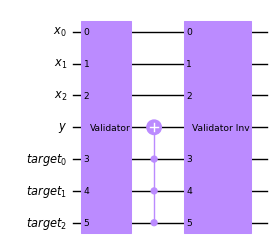

In [84]:
create_grover_oracle_circuit([1, 2, 3], 6, 3).draw(output = "mpl", scale = 0.7, fold = -1)

### Testing the Grover Oracle

{'1': 10}


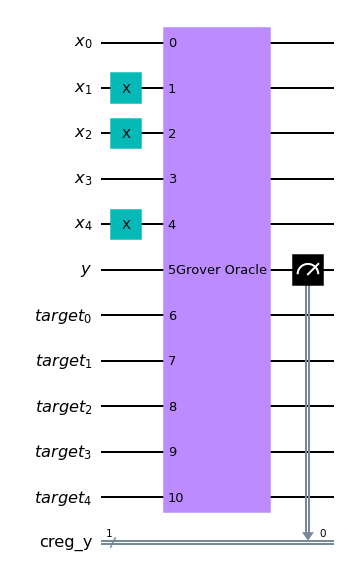

In [16]:
numbers_test = [5, 7, 8, 9, 1]
expected_sum_test = 16
digits_test = 5

# Setup qubits.
qreg_x = qiskit.QuantumRegister(len(numbers_test), "x")
qreg_y = qiskit.QuantumRegister(1, "y")
qreg_target = qiskit.QuantumRegister(digits_test, "target")
creg_y = qiskit.ClassicalRegister(1, "creg_y")
qc = qiskit.QuantumCircuit(qreg_x, qreg_y, qreg_target, creg_y)

# Setting up |x>.
# With each not operator, we enable the number to be added.
#qc.x(qreg_x[0])
qc.x(qreg_x[1])
qc.x(qreg_x[2])
#qc.x(qreg_x[3])
qc.x(qreg_x[4])

# Apply Grover Oracle
qc.append(create_grover_oracle_gate(numbers_test, expected_sum_test, digits_test),
    qreg_x[:] + qreg_y[:] + qreg_target[:])

# Measure values.
qc.measure(qreg_y, creg_y)

# Execute the circuit, print outcomes.
job = qiskit.execute(qc, qiskit.Aer.get_backend("qasm_simulator"), shots = 10)
counts = job.result().get_counts(qc)

# The bit for indicates whether the combination set
# adds up to expected_sum. If it is 1, then yes, 0 otherwise.
print(counts)
qc.draw(output = "mpl", scale = 1.0, fold = -1)

# Diffuser
The diffuser gate simply flips each amplitude around their mean. I am using almost the same method as https://qiskit.org/textbook/ch-algorithms/grover.html#3.-Example:-3-Qubits-. The reference calculates $-U_s$, and I apply a $-1$ multiplier at the end, so this gate calculates $U_s$.

The diffuser is applied to $|x\rangle$.

In [87]:
def create_diffuser_circuit(n):
    qreg_x = qiskit.QuantumRegister(n, "x")
    qc = qiskit.QuantumCircuit(qreg_x)
    
    qc.h(range(n))
    qc.x(range(n))
    
    # HXH = Z, so this is a multi controlled Z gate.
    qc.h(0)
    qc.mcx(list(range(1, n)), 0)
    qc.h(0)
    
    qc.x(range(n))
    qc.h(range(n))
    
    # ZXZX = -1
    qc.z(0)
    qc.x(0)
    qc.z(0)
    qc.x(0)
    
    return qc
def create_diffuser_gate(n):
    qc = create_diffuser_circuit(n)
    gate = qc.to_gate()
    gate.label = "Diffuser"
    return gate

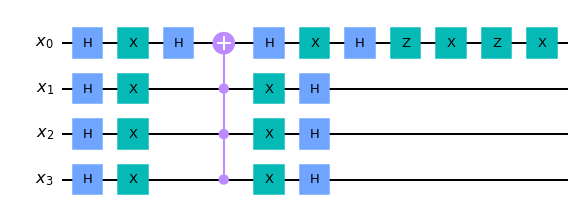

In [89]:
create_diffuser_circuit(4).draw(output = "mpl", scale = 1.0, fold = -1)

# Grover iterator
The Grover iterator combines the Grover Oracle and the diffuser together, and rotates the state in the $|s'\rangle$, $|w\rangle$ basis, where $|s'\rangle$ is the equal superposition of all the combination of $|x\rangle$, where $|x\rangle$ is not the solution, and $|w\rangle$ is the equal superposition of all the combination of $|x\rangle$, where $|x\rangle$ is the solution.

In [19]:
def create_grover_circuit(numbers, expected_sum, digits):
    qreg_x = qiskit.QuantumRegister(len(numbers), "x")
    qreg_y = qiskit.QuantumRegister(1, "y")
    qreg_target = qiskit.QuantumRegister(digits, "target")
    qc = qiskit.QuantumCircuit(qreg_x, qreg_y, qreg_target)

    # Apply Grover Oracle
    qc.append(create_grover_oracle_gate(numbers, expected_sum, digits),
        qreg_x[:] + qreg_y[:] + qreg_target[:])

    qc.append(create_diffuser_gate(len(numbers)), qreg_x)

    return qc
def create_grover_gate(numbers, expected_sum, digits):
    qc = create_grover_circuit(numbers, expected_sum, digits)
    gate = qc.to_gate()
    gate.label = "Grover"
    return gate

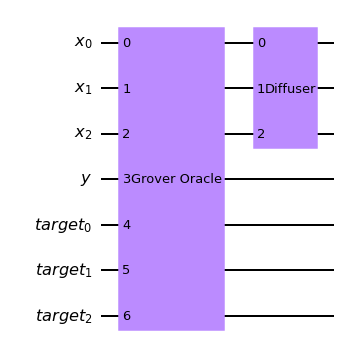

In [91]:
create_grover_circuit([1, 2, 3], 6, 3).draw(output = "mpl", scale = 1.0, fold = -1)

## Testing the Grover iterator

{'01001': 2, '11100': 1, '01101': 48, '01010': 37, '00111': 1, '11010': 1, '01011': 2, '10001': 1, '01000': 1, '11101': 1, '10011': 1, '00010': 1, '00001': 1, '00000': 1, '11011': 1}


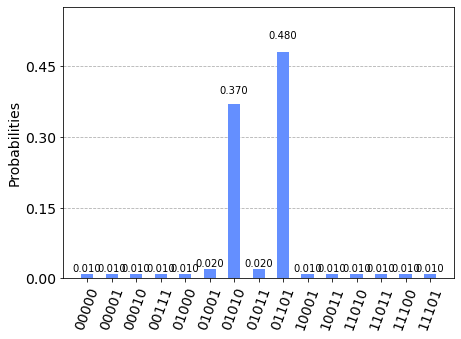

In [21]:
numbers_test = [5, 7, 8, 9, 1]
expected_sum_test = 16
digits_test = 5

# Setup qubits.
qreg_x = qiskit.QuantumRegister(len(numbers_test), "x")
qreg_y = qiskit.QuantumRegister(1, "y")
qreg_target = qiskit.QuantumRegister(digits_test, "target")
creg_x = qiskit.ClassicalRegister(len(numbers_test), "creg_x")
qc = qiskit.QuantumCircuit(qreg_x, qreg_y, qreg_target, creg_x)

# Set the |x> to the superposition of all possible combinations.
qc.h(qreg_x)

# Set the |y> to |->.
qc.x(qreg_y)
qc.h(qreg_y)

# Apply Grover iterator n times
n = 2
for i in range(n):
    qc.append(create_grover_gate(numbers_test, expected_sum_test, digits_test),
        qreg_x[:] + qreg_y[:] + qreg_target[:])

# We only want to measure the values of |x>, the combinations.
qc.measure(qreg_x, creg_x)

# Execute the circuit, print outcomes.
job = qiskit.execute(qc, qiskit.Aer.get_backend("qasm_simulator"), shots = 100)
counts = job.result().get_counts(qc)

# Format result. Flip the binary of |x>.
counts_formatted = {}
for key in counts:
    key_formatted = key[::-1]
    counts_formatted[key_formatted] = counts[key]
print(counts_formatted)
qiskit.visualization.plot_histogram(counts_formatted)
#qc.draw(output = "mpl", scale = 0.7, fold = -1)

# Counting the solutions
The number of solutions must be counted, in order to figure out how many times the Grover iterator needs to be applied.
This is done by the well-known quantum counting algorithm.

In [94]:
def create_controlled_grover_gate(numbers, expected_sum, digits):
    gate = create_grover_gate(numbers, expected_sum, digits).control()
    return gate

def create_counter_circuit(numbers, expected_sum, digits, digits_counter):
    qreg_t = qiskit.QuantumRegister(digits_counter, "t")
    qreg_x = qiskit.QuantumRegister(len(numbers), "x")
    qreg_y = qiskit.QuantumRegister(1, "y")
    qreg_target = qiskit.QuantumRegister(digits, "target")
    qc = qiskit.QuantumCircuit(qreg_t, qreg_x, qreg_y, qreg_target)

    # Set the |x> and |t> to the superposition of all possible combinations.
    qc.h(qreg_x)
    qc.h(qreg_t)

    # Set the |y> to |->.
    qc.x(qreg_y)
    qc.h(qreg_y)

    # Apply Grover iterator n times
    

# Apply Grover iterator n times
    n = 1
    for i in range(digits_counter):
        for j in range(n):
            qc.append(create_controlled_grover_gate(numbers, expected_sum, digits),
                [qreg_t[i]] + qreg_x[:] + qreg_y[:] + qreg_target[:])
        n *= 2

    qc.append(create_qft_inverse_gate(digits_counter), qreg_t)
    
    return qc
def create_counter_gate(numbers, expected_sum, digits, digits_counter):
    qc = create_counter_circuit(numbers, expected_sum, digits, digits_counter)
    gate = qc.to_gate()
    gate.label = "Counter"
    return gate

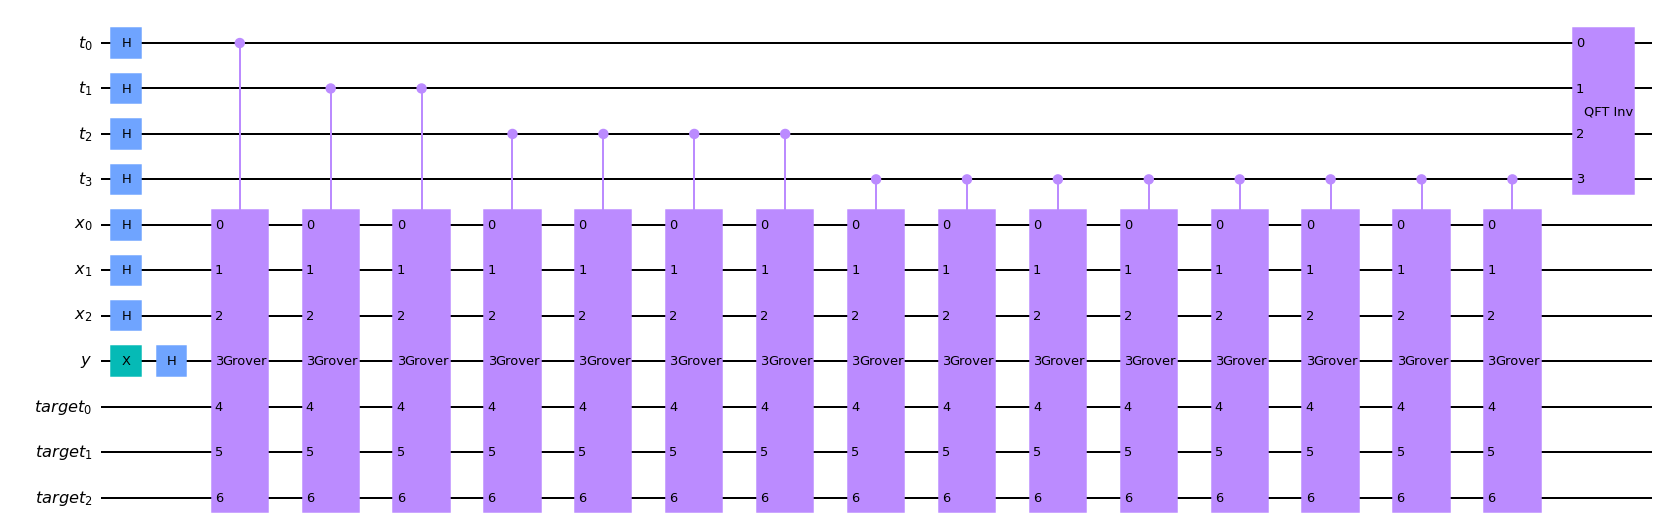

In [96]:
create_counter_circuit([1, 2, 3], 6, 3, 4).draw(output = "mpl", scale = 1.0, fold = -1)

## Testing the counter

{'00010': 40, '11111': 4, '11110': 48, '00011': 2, '11011': 1, '00001': 2, '00110': 1, '11101': 2}
{2: 40, 31: 4, 30: 48, 3: 2, 27: 1, 1: 2, 6: 1, 29: 2}


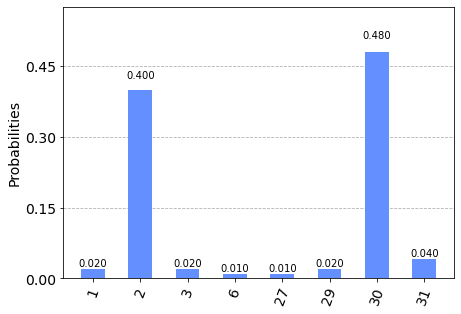

In [56]:
numbers_test = [4, 6, 8, 5, 3]
expected_sum_test = 16
digits_test = 5
digits_counter_test = 5

# Setup qubits.
qreg_t = qiskit.QuantumRegister(digits_counter_test, "t")
qreg_x = qiskit.QuantumRegister(len(numbers_test), "x")
qreg_y = qiskit.QuantumRegister(1, "y")
qreg_target = qiskit.QuantumRegister(digits_test, "target")
creg_t = qiskit.ClassicalRegister(digits_counter_test, "creg_t")
qc = qiskit.QuantumCircuit(qreg_t, qreg_x, qreg_y, qreg_target, creg_t)

# Applying the counter.
qc.append(create_counter_gate(numbers_test, expected_sum_test, digits_test, digits_counter_test),
    qreg_t[:] + qreg_x[:] + qreg_y[:] + qreg_target[:])

# We only want to measure the values of |x>, the combinations.
qc.measure(qreg_t, creg_t)

# Execute the circuit, print outcomes.
job = qiskit.execute(qc, qiskit.Aer.get_backend("qasm_simulator"), shots = 100)
counts = job.result().get_counts(qc)

# Format the result.
counts_int = {}
for key in counts:
    new_key = int(key[0:digits_counter_test], 2)
    counts_int[new_key] = counts[key]
print(counts)
print(counts_int)
qiskit.visualization.plot_histogram(counts_int)
#qc.draw(output = "mpl", scale = 0.7, fold = -1)

## Counter calculations

In [57]:
# Returns with the approximate number of solutions,
# and with the optimal number of iterations for the Grover algorithm.
def calculate_counter_result(result, len_numbers, digits_counter):
    theta = numpy.pi * result / 2 ** digits_counter
    number_of_solutions = 2 ** len_numbers * numpy.sin(theta) ** 2
    
    # There are two solutions we can measure: theta or pi-theta,
    # and 0 <= theta <= pi/2.
    # If we measured >pi/2, we make a correction.
    if theta > numpy.pi / 2:
        theta = numpy.pi - theta
    optimal_number_of_iterations = numpy.pi / (4 * theta) - 0.5
    
    return (number_of_solutions, optimal_number_of_iterations)

In [59]:
result = 2
(number_of_solutions, optimal_number_of_iterations) =\
    calculate_counter_result(result, len(numbers_test), digits_counter_test)
    
print("approximate number of solutions: " + str(number_of_solutions))
print("optimal number of iterations: " + str(optimal_number_of_iterations))

approximate number of solutions: 1.2179274798194117
optimal number of iterations: 3.5


# Main functions

{'01101': 47, '10010': 1, '10000': 1, '01010': 48, '11001': 1, '11110': 1, '00110': 1}


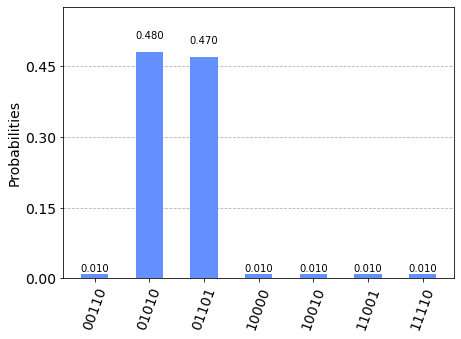

In [55]:
def count_optimal_iterations(numbers, expected_sum, digits, digits_counter, shots_counter):
    qreg_t = qiskit.QuantumRegister(digits_counter, "t")
    qreg_x = qiskit.QuantumRegister(len(numbers), "x")
    qreg_y = qiskit.QuantumRegister(1, "y")
    qreg_target = qiskit.QuantumRegister(digits, "target")
    creg_t = qiskit.ClassicalRegister(digits_counter, "creg_t")
    qc = qiskit.QuantumCircuit(qreg_t, qreg_x, qreg_y, qreg_target, creg_t)

    # Applying the counter.
    qc.append(create_counter_gate(numbers, expected_sum, digits, digits_counter),
        qreg_t[:] + qreg_x[:] + qreg_y[:] + qreg_target[:])

    # We only want to measure the values of |x>, the combinations.
    qc.measure(qreg_t, creg_t)

    # Execute the circuit, print outcomes.
    job = qiskit.execute(qc, qiskit.Aer.get_backend("qasm_simulator"), shots = shots_counter)
    counts = job.result().get_counts(qc)
    
    # If there's no solutions, we return with False.
    # No solutions, if the no solutions has more than 0.5 probability.
    if ("0" * digits_counter) in counts and counts["0" * digits_counter] > shots_counter / 2:
        return False

    # Format the result.
    counts_int = {}
    for key in counts:
        new_key = int(key[0:digits_counter], 2)
        if new_key != 0:
            counts_int[new_key] = counts[key]
    result = max(counts_int)
    return calculate_counter_result(result, len(numbers), digits_counter)

def find_indices(numbers, expected_sum, digits, digits_counter, shots, shots_counter):
    # First, we decide how many times Grover iterator needs to be applied.
    counter_results = count_optimal_iterations(numbers, expected_sum, digits, digits_counter, shots_counter)
    if not counter_results:
        return False

    (number_of_solutions, optimal_number_of_iterations) = counter_results

    #print("approximate number of solutions: " + str(number_of_solutions))
    #print("optimal number of iterations: " + str(optimal_number_of_iterations))

    # Setup qubits.
    qreg_x = qiskit.QuantumRegister(len(numbers), "x")
    qreg_y = qiskit.QuantumRegister(1, "y")
    qreg_target = qiskit.QuantumRegister(digits, "target")
    creg_x = qiskit.ClassicalRegister(len(numbers), "creg_x")
    qc = qiskit.QuantumCircuit(qreg_x, qreg_y, qreg_target, creg_x)

    # Set the |x> to the superposition of all possible combinations.
    qc.h(qreg_x)

    # Set the |y> to |->.
    qc.x(qreg_y)
    qc.h(qreg_y)

    # Apply Grover iterator n times
    for i in range(round(optimal_number_of_iterations)):
        qc.append(create_grover_gate(numbers, expected_sum, digits),
            qreg_x[:] + qreg_y[:] + qreg_target[:])

    # We only want to measure the values of |x>, the combinations.
    qc.measure(qreg_x, creg_x)

    # Execute the circuit, print outcomes.
    job = qiskit.execute(qc, qiskit.Aer.get_backend("qasm_simulator"), shots = shots)
    counts = job.result().get_counts(qc)

    # Format result. Flip the binary of |x>.
    counts_formatted = {}
    for key in counts:
        key_formatted = key[::-1]
        counts_formatted[key_formatted] = counts[key]
    return counts_formatted

# Setup parameters for the calculation.
numbers = [5, 7, 8, 9, 1]
expected_sum = 16
digits = 5
# Let's set the counter qubits to ceil(numbers/2).
# We need to apply the Grover iterator 2^digits_counter-1 times,
# and to get the complexity similar to the Grover search,
# we set it to roughly sqrt(2^len(numbers)).
# For small lists, this parameter is crucial, we add +1.
digits_counter = int(numpy.ceil(len(numbers) / 2)) + 1
#digits_counter = 5
# Number of measurements.
shots = 100
shots_counter = 100

results = find_indices(numbers, expected_sum, digits, digits_counter, shots, shots_counter)
print(results)
qiskit.visualization.plot_histogram(results)